
# LangGraph 2.2 Tutorial: Advanced State Management and Multi-Node Processing in Production

Let's combine all the concepts into a production-ready conversational agent that demonstrates best practices for state management and multi-node processing.

### Pipeline Architecture:
1. **Message Processor**: Initial message handling
2. **Window Manager**: Memory optimization
3. **Summarizer**: Context preservation
4. **Response Generator**: Final output creation

### Benefits of Multi-Node Architecture:
- **Separation of Concerns**: Each node has a specific responsibility
- **Testability**: Individual nodes can be tested in isolation
- **Scalability**: Easy to add or modify nodes
- **Maintainability**: Clear, modular code structure

## Setting Up Our Environment

Before we dive into advanced patterns, let's ensure our environment is properly configured with all necessary dependencies.


In [23]:
# Install required packages
%pip install langgraph langchain langchain-openai python-dotenv --quiet


Note: you may need to restart the kernel to use updated packages.


In [24]:
import os
from typing import Annotated, TypedDict, List
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set API keys
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')

# Import core dependencies
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate


In [25]:
class State(TypedDict):
    """
    Enhanced state container with context management capabilities.
    
    This implementation demonstrates advanced state management by tracking:
    1. Message history with proper LangGraph annotations
    2. Conversation summaries for context retention
    3. Memory window control for efficient processing
    
    Attributes:
        messages: List of conversation messages with LangGraph's add_messages
                 annotation for proper message handling
        summary: Running summary of the conversation context
        window_size: Control parameter for message history retention
        
    Note:
        The add_messages annotation is crucial for proper message
        handling in LangGraph, ensuring correct state updates while
        the additional fields enable sophisticated conversation management.
    """
    messages: Annotated[list[BaseMessage], add_messages]
    summary: str
    window_size: int


In [26]:
# Initialize LLM for summarization
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Window Manager


In [27]:
def manage_message_window(state: State) -> State:
    """
    Maintain optimal message history through window-based pruning.
    
    This function implements several key concepts:
    1. Automatic message pruning
    2. Window-based history management
    3. State preservation during updates
    
    Args:
        state: Current conversation state with messages and window configuration
        
    Returns:
        State: Updated state with windowed message history
    """
    current_window_size = state.get("window_size", 5)
    current_messages = state["messages"]
    
    # Check if pruning is needed
    if len(current_messages) > current_window_size:
        # Before pruning, update summary with older messages
        older_messages = current_messages[:-current_window_size]
        summary_addition = " Previous context: " + "; ".join([
            f"{type(msg).__name__}: {msg.content[:50]}..." 
            for msg in older_messages
        ])
        
        # Prune messages to window size
        pruned_messages = current_messages[-current_window_size:]
        
        # Update state with pruned messages and enhanced summary
        return {
            "messages": pruned_messages,
            "summary": state["summary"] + summary_addition,
            "window_size": current_window_size
        }
    
    # No pruning needed
    return state


# Dynamic summary


In [28]:
# Initialize LLM for summarization
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

def generate_dynamic_summary(state: State) -> State:
    """
    Generate and maintain dynamic conversation summaries.
    
    This function implements:
    1. Threshold-based summary generation
    2. Context preservation through summarization
    3. Integration with LLM for intelligent summaries
    
    Args:
        state: Current conversation state
        
    Returns:
        State: Updated state with new summary
    """
    messages = state["messages"]
    
    # Only summarize if we have enough messages
    if len(messages) < 3:
        return state
    
    # Check if summary needs updating (every N messages)
    if len(messages) % 3 == 0:
        # Create conversation text for summarization
        conversation_text = "\n".join([
            f"{type(msg).__name__.replace('Message', '')}: {msg.content}"
            for msg in messages[-5:]  # Summarize last 5 messages
        ])
        
        # Use LLM to generate summary
        summary_prompt = PromptTemplate(
            input_variables=["conversation", "previous_summary"],
            template="""Based on the previous summary and recent conversation, create a concise updated summary.

Previous Summary: {previous_summary}

Recent Conversation:
{conversation}

Updated Summary (2-3 sentences):"""
        )
        
        summary_response = llm.invoke(
            summary_prompt.format(
                conversation=conversation_text,
                previous_summary=state.get("summary", "No previous summary")
            )
        )
        
        return {
            "messages": messages,
            "summary": summary_response.content,
            "window_size": state["window_size"]
        }
    
    return state


### Define nodes 


In [29]:

# Define specialized nodes for our pipeline

def message_processor_node(state: State) -> State:
    """
    Initial message processing node.
    Handles new messages and prepares them for the pipeline.
    """
    if not state["messages"]:
        return {
            "messages": [SystemMessage(content="System initialized")],
            "summary": "New conversation started",
            "window_size": state.get("window_size", 5)
        }
    
    # Process the last human message if present
    last_human_msg = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_msg = msg
            break
    
    if last_human_msg:
        # Add processing metadata
        print(f"[Processor] Processing: {last_human_msg.content[:50]}...")
    
    return state

def window_manager_node(state: State) -> State:
    """
    Window management node.
    Ensures message history stays within configured limits.
    """
    print(f"[Window Manager] Current messages: {len(state['messages'])}, Window: {state['window_size']}")
    return manage_message_window(state)

def summarizer_node(state: State) -> State:
    """
    Summarization node.
    Creates or updates conversation summaries.
    """
    # Only summarize if we have enough messages
    if len(state["messages"]) >= 3:
        print(f"[Summarizer] Generating summary for {len(state['messages'])} messages")
        return generate_dynamic_summary(state)
    return state

def response_generator_node(state: State) -> State:
    """
    Response generation node.
    Creates appropriate responses based on the processed state.
    """
    # Check if we need to generate a response
    last_msg = state["messages"][-1] if state["messages"] else None
    
    if isinstance(last_msg, HumanMessage):
        # Generate context-aware response
        context = f"Summary: {state['summary']}\nUser: {last_msg.content}"
        
        prompt = PromptTemplate(
            input_variables=["context"],
            template="""Based on the conversation context, provide a helpful response.

{context}

Response:"""
        )
        
        response = llm.invoke(prompt.format(context=context))
        
        print(f"[Response Generator] Generated response")
        
        return {
            "messages": [AIMessage(content=response.content)],
            "summary": state["summary"],
            "window_size": state["window_size"]
        }
    
    return state


In [30]:
# Define specialized nodes for our pipeline

def message_processor_node(state: State) -> State:
    """
    Initial message processing node.
    Handles new messages and prepares them for the pipeline.
    """
    if not state["messages"]:
        return {
            "messages": [SystemMessage(content="System initialized")],
            "summary": "New conversation started",
            "window_size": state.get("window_size", 5)
        }
    
    # Process the last human message if present
    last_human_msg = None
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            last_human_msg = msg
            break
    
    if last_human_msg:
        # Add processing metadata
        print(f"[Processor] Processing: {last_human_msg.content[:50]}...")
    
    return state

def window_manager_node(state: State) -> State:
    """
    Window management node.
    Ensures message history stays within configured limits.
    """
    print(f"[Window Manager] Current messages: {len(state['messages'])}, Window: {state['window_size']}")
    return manage_message_window(state)

def summarizer_node(state: State) -> State:
    """
    Summarization node.
    Creates or updates conversation summaries.
    """
    # Only summarize if we have enough messages
    if len(state["messages"]) >= 3:
        print(f"[Summarizer] Generating summary for {len(state['messages'])} messages")
        return generate_dynamic_summary(state)
    return state

def response_generator_node(state: State) -> State:
    """
    Response generation node.
    Creates appropriate responses based on the processed state.
    """
    # Check if we need to generate a response
    last_msg = state["messages"][-1] if state["messages"] else None
    
    if isinstance(last_msg, HumanMessage):
        # Generate context-aware response
        context = f"Summary: {state['summary']}\nUser: {last_msg.content}"
        
        prompt = PromptTemplate(
            input_variables=["context"],
            template="""Based on the conversation context, provide a helpful response.

{context}

Response:"""
        )
        
        response = llm.invoke(prompt.format(context=context))
        
        print(f"[Response Generator] Generated response")
        
        return {
            "messages": [AIMessage(content=response.content)],
            "summary": state["summary"],
            "window_size": state["window_size"]
        }
    
    return state


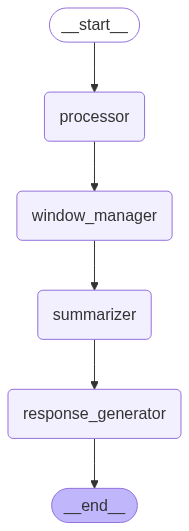

In [31]:
# Build the multi-node pipeline
def create_advanced_pipeline():
    """
    Create a complete multi-node processing pipeline.
    """
    # Initialize the graph
    graph = StateGraph(State)
    
    # Add all nodes
    graph.add_node("processor", message_processor_node)
    graph.add_node("window_manager", window_manager_node)
    graph.add_node("summarizer", summarizer_node)
    graph.add_node("response_generator", response_generator_node)
    
    # Define the flow
    graph.add_edge(START, "processor")
    graph.add_edge("processor", "window_manager")
    graph.add_edge("window_manager", "summarizer")
    graph.add_edge("summarizer", "response_generator")
    graph.add_edge("response_generator", END)
    
    # Compile the graph
    return graph.compile()

# Create and visualize the pipeline
pipeline = create_advanced_pipeline()

# Visualize the pipeline structure
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

try:
    display(
        Image(
            pipeline.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Visualization not available: {e}")
    print("\nPipeline structure:")
    print("START -> processor -> window_manager -> summarizer -> response_generator -> END")


In [32]:
# Test the complete pipeline
print("\nTesting Multi-Node Pipeline:")
print("=" * 60)

# Initialize conversation state
conversation_state = {
    "messages": [],
    "summary": "",
    "window_size": 3
}

# Simulate a conversation
test_messages = [
    "Hello! I'm interested in learning about LangGraph",
    "What are the key features of LangGraph?",
    "How does it compare to other frameworks?",
    "Can you show me a simple example?",
    "What about error handling?"
]

for i, user_msg in enumerate(test_messages):
    print(f"\n--- Turn {i+1} ---")
    print(f"User: {user_msg}")
    
    # Add user message to state
    conversation_state["messages"].append(HumanMessage(content=user_msg))
    
    # Process through pipeline
    result = pipeline.invoke(conversation_state)
    
    # Update conversation state
    conversation_state = result
    
    # Display the response
    if result["messages"]:
        last_msg = result["messages"][-1]
        if isinstance(last_msg, AIMessage):
            print(f"Assistant: {last_msg.content[:150]}...")
    
    print(f"\nState Info:")
    print(f"  Messages in memory: {len(result['messages'])}")
    print(f"  Summary length: {len(result['summary'])} chars")



Testing Multi-Node Pipeline:

--- Turn 1 ---
User: Hello! I'm interested in learning about LangGraph
[Processor] Processing: Hello! I'm interested in learning about LangGraph...
[Window Manager] Current messages: 1, Window: 3
[Response Generator] Generated response
Assistant: Hello! LangGraph is a framework designed to facilitate the development of applications that leverage language models and graph-based data structures. ...

State Info:
  Messages in memory: 2
  Summary length: 0 chars

--- Turn 2 ---
User: What are the key features of LangGraph?
[Processor] Processing: What are the key features of LangGraph?...
[Window Manager] Current messages: 3, Window: 3
[Summarizer] Generating summary for 3 messages
[Response Generator] Generated response
Assistant: LangGraph offers several key features that enhance the development of applications using language models and graph-based data structures:

1. **Graph ...

State Info:
  Messages in memory: 4
  Summary length: 409 chars

--- Turn 3

KeyboardInterrupt: 

## Putting It All Together: Production-Ready Patterns

Let's combine all the concepts into a production-ready conversational agent that demonstrates best practices for state management and multi-node processing.


In [33]:
class ProductionState(TypedDict):
    """
    Production-ready state with comprehensive tracking.
    """
    messages: Annotated[list[BaseMessage], add_messages]
    summary: str
    window_size: int
    conversation_metadata: dict  # Track conversation metrics
    user_context: dict  # Store user preferences/info

In [34]:
# Enhanced message processor with metadata tracking
def enhanced_processor(state: ProductionState) -> ProductionState:
        """Process messages and update metadata."""
        metadata = state.get("conversation_metadata", {})
        metadata["total_messages"] = metadata.get("total_messages", 0) + 1
        metadata["last_updated"] = "now"
        
        # Extract user context from messages
        user_context = state.get("user_context", {})
        if state["messages"]:
            last_msg = state["messages"][-1]
            if isinstance(last_msg, HumanMessage):
                # Simple intent detection
                content_lower = last_msg.content.lower()
                if "my name is" in content_lower:
                    # Extract name (simplified)
                    words = last_msg.content.split()
                    if "is" in words:
                        idx = words.index("is")
                        if idx < len(words) - 1:
                            user_context["name"] = words[idx + 1].strip(".,!?")
        
        return {
            **state,
            "conversation_metadata": metadata,
            "user_context": user_context
        }

In [38]:
# Smart response generator using all context
def smart_response_generator(state: ProductionState) -> ProductionState:
        """Generate responses using full context."""
        last_msg = state["messages"][-1] if state["messages"] else None
        
        if isinstance(last_msg, HumanMessage):
            # Build comprehensive context
            context_parts = [
                f"Summary: {state.get('summary', 'No summary yet')}"
            ]
            
            # Add user context if available
            if state.get("user_context", {}).get("name"):
                context_parts.append(f"User name: {state['user_context']['name']}")
            
            # Add conversation metadata
            metadata = state.get("conversation_metadata", {})
            if metadata.get("total_messages"):
                context_parts.append(f"Messages exchanged: {metadata['total_messages']}")
            
            context_parts.append(f"User message: {last_msg.content}")
            
            full_context = "\n".join(context_parts)
            
            prompt = PromptTemplate(
                input_variables=["context"],
                template="""You are a helpful assistant. Use all available context to provide personalized responses.
                
                Context:
                {context}

                Provide a helpful, personalized response:"""
            )
            
            response = llm.invoke(prompt.format(context=full_context))
            
            return {
                **state,
                "messages": [AIMessage(content=response.content)]
            }
        
        return state

In [39]:

def create_production_agent():
    """
    Create a production-ready conversational agent with all best practices.
    """
    graph = StateGraph(ProductionState)
    
    # Add nodes
    graph.add_node("enhanced_processor", enhanced_processor)
    graph.add_node("window_manager", window_manager_node)
    graph.add_node("summarizer", summarizer_node)
    graph.add_node("smart_responder", smart_response_generator)
    
    # Define flow
    graph.add_edge(START, "enhanced_processor")
    graph.add_edge("enhanced_processor", "window_manager")
    graph.add_edge("window_manager", "summarizer")
    graph.add_edge("summarizer", "smart_responder")
    graph.add_edge("smart_responder", END)
    
    return graph.compile()

# Create production agent
production_agent = create_production_agent()


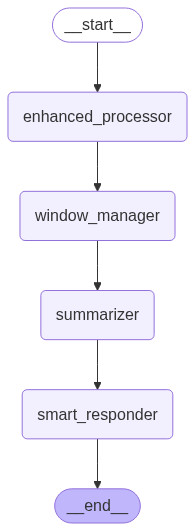

In [40]:
# Visualize the pipeline structure
from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod

try:
    display(
        Image(
            production_agent.get_graph().draw_mermaid_png(
                draw_method=MermaidDrawMethod.API,
            )
        )
    )
except Exception as e:
    print(f"Visualization not available: {e}")
    print("\nPipeline structure:")
    print("START -> processor -> window_manager -> summarizer -> response_generator -> END")

In [41]:
# Test the production agent
print("\nTesting Production Agent:")
print("=" * 60)

# Initialize state
prod_state = {
    "messages": [],
    "summary": "",
    "window_size": 4,
    "conversation_metadata": {},
    "user_context": {}
}

# Simulate a personalized conversation
production_messages = [
    "Hello! My name is Alex",
    "I want to learn about building agents with LangGraph",
    "What makes it different from regular chatbots?",
    "Can you give me a specific example?",
    "Thanks, this is really helpful!"
]

for i, msg in enumerate(production_messages):
    print(f"\n--- Turn {i+1} ---")
    print(f"User: {msg}")
    
    # Add message and process
    prod_state["messages"].append(HumanMessage(content=msg))
    result = production_agent.invoke(prod_state)
    prod_state = result
    
    # Show response
    if result["messages"]:
        last_msg = result["messages"][-1]
        if isinstance(last_msg, AIMessage):
            print(f"Assistant: {last_msg.content[:200]}...")
    
    # Show enhanced state info
    print(f"\nEnhanced State:")
    print(f"  Window: {len(result['messages'])}/{result['window_size']}")
    print(f"  User Context: {result.get('user_context', {})}")
    print(f"  Metadata: {result.get('conversation_metadata', {})}")



Testing Production Agent:

--- Turn 1 ---
User: Hello! My name is Alex
[Window Manager] Current messages: 1, Window: 4
Assistant: Hello, Alex! It's great to meet you! How can I assist you today? If there's anything specific you'd like to talk about or any questions you have, feel free to share!...

Enhanced State:
  Window: 2/4
  User Context: {'name': 'Alex'}
  Metadata: {'total_messages': 1, 'last_updated': 'now'}

--- Turn 2 ---
User: I want to learn about building agents with LangGraph
[Window Manager] Current messages: 3, Window: 4
[Summarizer] Generating summary for 3 messages
Assistant: Hi Alex! I'm excited to help you learn about building agents with LangGraph. To get started, it would be helpful to know what specific aspects you're interested in. Are you looking for an overview of ...

Enhanced State:
  Window: 4/4
  User Context: {'name': 'Alex'}
  Metadata: {'total_messages': 2, 'last_updated': 'now'}

--- Turn 3 ---
User: What makes it different from regular chatbots?
[Win

## Next Steps

Now that you've mastered advanced state management and multi-node processing:

### 1. **Experiment with Different Architectures**
- Try parallel node execution
- Implement conditional routing
- Create branching pipelines

### 2. **Add Advanced Features**
- Implement state persistence
- Add conversation analytics
- Create custom state validators

### 3. **Optimize for Production**
- Add comprehensive error handling
- Implement retry logic
- Create health checks

### 4. **Explore Integration**
- Connect to external APIs
- Add tool usage capabilities
- Implement multi-agent coordination

### 5. **Study Real-World Examples**
- Review the LangGraph documentation
- Explore community examples
- Build your own production system

## Resources

- [LangGraph Documentation](https://langchain-ai.github.io/langgraph/)
- [AI Product Engineer Tutorials](https://aiproduct.engineer/tutorials/)
- [LangChain Community](https://github.com/langchain-ai/langchain)

Happy building! 🚀
